In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [136]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.metrics import r2_score, accuracy_score, mean_absolute_error, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.compose import  ColumnTransformer

Problem statement:Consider a real estate company that has a dataset containing the prices of properties in the Delhi region. It wishes to use the data to optimise the sale prices of the properties based on important factors such as area, bedrooms, parking, etc.

Essentially, the company wants:

     1.To identify the variables affecting house prices, e.g. area, number of rooms, bathrooms, etc.

     2.To create a linear model that quantitatively relates house prices with variables such as number of rooms, area, number of bathrooms
     , etc.
     3.To know the accuracy of the model, i.e. how well these variables can predict house prices.
     
(Note:use regularization concept to avoid over-fitting)

In [5]:
pd.set_option("display.max_columns",None)

In [7]:
df = pd.read_csv("C:\\Datasets\\Housing.csv")
df.sample(10)

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
439,3255000,3930,2,1,1,no,no,no,no,no,0,no,unfurnished
520,2450000,7700,2,1,1,yes,no,no,no,no,0,no,unfurnished
257,4480000,8250,3,1,1,yes,no,no,no,no,0,no,furnished
188,5075000,5720,2,1,2,yes,no,no,no,yes,0,yes,unfurnished
112,6083000,4300,6,2,2,yes,no,no,no,no,0,no,furnished
356,3773000,2520,5,2,1,no,no,yes,no,yes,1,no,furnished
400,3500000,3512,2,1,1,yes,no,no,no,no,1,yes,unfurnished
469,3010000,4600,2,1,1,yes,no,no,no,no,0,no,furnished
525,2345000,3640,2,1,1,yes,no,no,no,no,0,no,unfurnished
119,5950000,7020,3,1,1,yes,no,yes,no,yes,2,yes,semi-furnished


In [11]:
df_num = df.select_dtypes(exclude="object")
df_cat = df.select_dtypes(include="object")

In [13]:
df_num.describe()

,price,area,bedrooms,bathrooms,stories,parking
count,5.450000e+02,545.000000,545.000000,545.000000,545.000000,545.000000
mean,4.766729e+06,5150.541284,2.965138,1.286239,1.805505,0.693578
std,1.870440e+06,2170.141023,0.738064,0.502470,0.867492,0.861586
min,1.750000e+06,1650.000000,1.000000,1.000000,1.000000,0.000000
25%,3.430000e+06,3600.000000,2.000000,1.000000,1.000000,0.000000
50%,4.340000e+06,4600.000000,3.000000,1.000000,2.000000,0.000000
75%,5.740000e+06,6360.000000,3.000000,2.000000,2.000000,1.000000
max,1.330000e+07,16200.000000,6.000000,4.000000,4.000000,3.000000


In [15]:
df_cat.describe()

,mainroad,guestroom,basement,hotwaterheating,airconditioning,prefarea,furnishingstatus
count,545,545,545,545,545,545,545
unique,2,2,2,2,2,2,3
top,yes,no,no,no,no,no,semi-furnished
freq,468,448,354,520,373,417,227


In [17]:
df_num.isna().sum()

price        0
area         0
bedrooms     0
bathrooms    0
stories      0
parking      0
dtype: int64

In [19]:
df_cat.isna().sum()

mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
prefarea            0
furnishingstatus    0
dtype: int64

In [25]:
for col in df_cat.columns:
    print("-"*20)
    print(df_cat[col].value_counts())

--------------------
mainroad
yes    468
no      77
Name: count, dtype: int64
--------------------
guestroom
no     448
yes     97
Name: count, dtype: int64
--------------------
basement
no     354
yes    191
Name: count, dtype: int64
--------------------
hotwaterheating
no     520
yes     25
Name: count, dtype: int64
--------------------
airconditioning
no     373
yes    172
Name: count, dtype: int64
--------------------
prefarea
no     417
yes    128
Name: count, dtype: int64
--------------------
furnishingstatus
semi-furnished    227
unfurnished       178
furnished         140
Name: count, dtype: int64


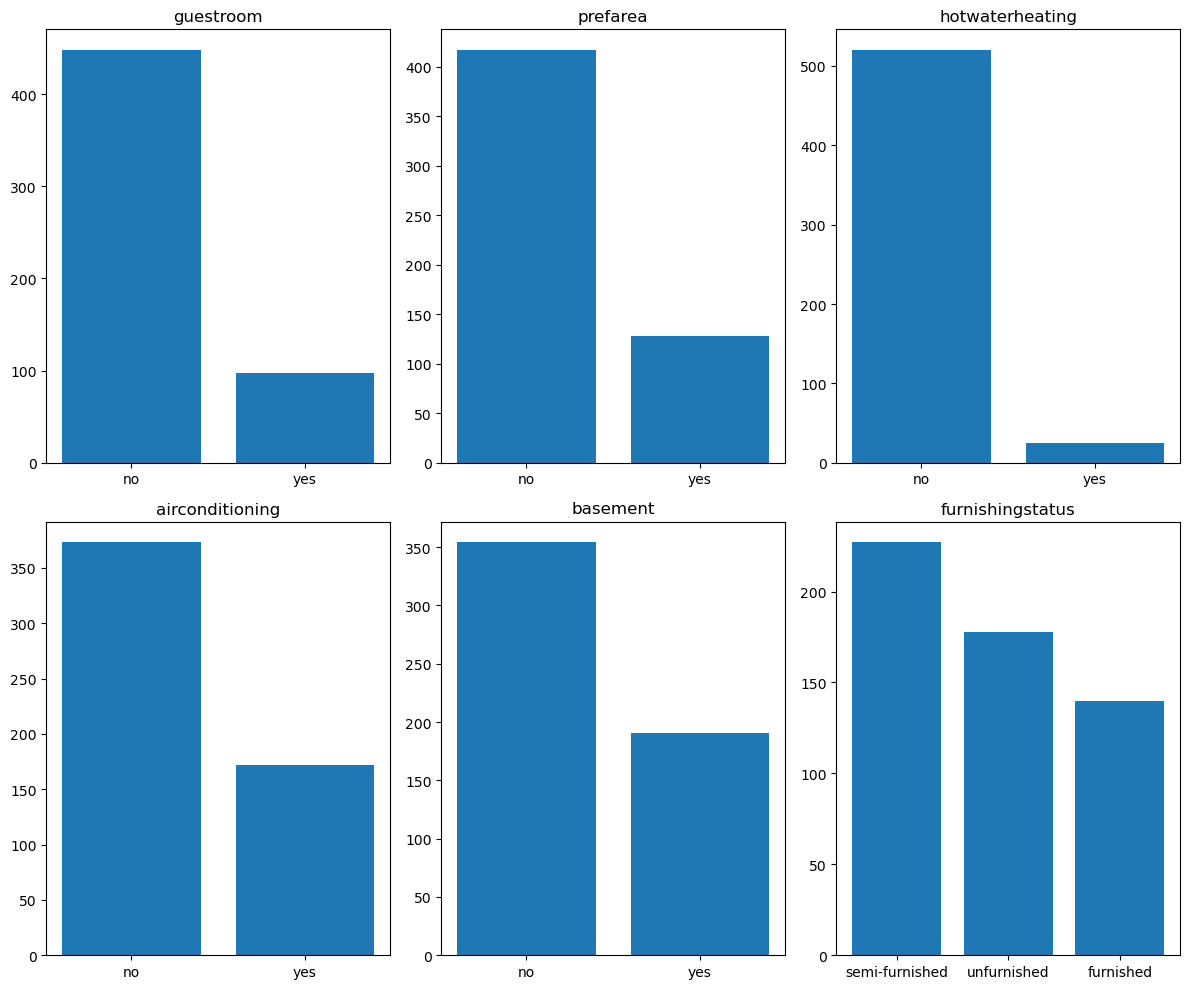

In [77]:
fig,ax =plt.subplots(2,3,figsize=(12,10))
plt.title("Categorical Value Plot")

for pos,col in enumerate(df_cat.columns[1:]):
    #print(pos%2,pos%3)
    ax[pos%2,pos%3].set_title(f"{col}")
    data = df_cat[col].value_counts().reset_index()
    ax[pos%2,pos%3].bar(data.iloc[:,0],data.iloc[:,1])

plt.tight_layout()

Text(0.5, 1.0, 'Correlation HeatMap')

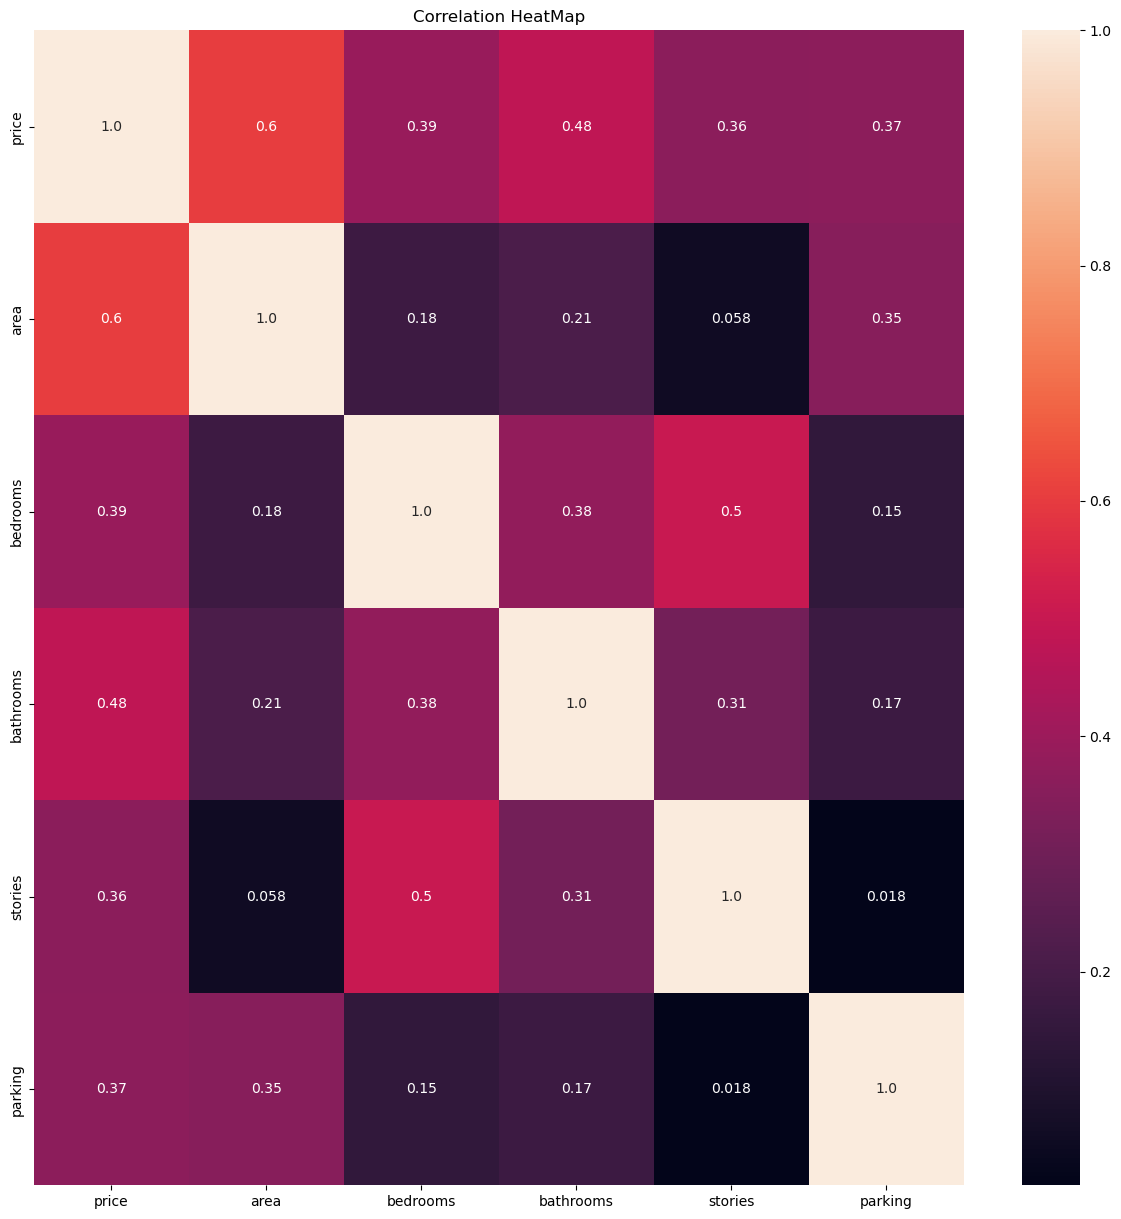

In [41]:
plt.figure(figsize=(15,15))
sns.heatmap(df_num.corr(method="spearman"), annot= True, fmt="0.2")
plt.title("Correlation HeatMap")


In [98]:
furnish_group = df.groupby("furnishingstatus")

<Axes: xlabel='furnishingstatus'>

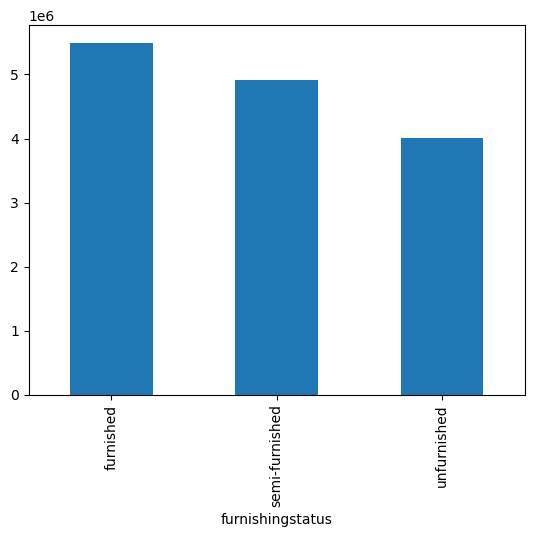

In [112]:
data = furnish_group["price"].mean().round(2)
fig,axs = plt.subplots()
data.plot(kind="bar")

In [114]:
data = furnish_group[['area', 'bedrooms', 'bathrooms', 'stories', 'parking']].mean().round(2)
#fig,axs = plt.subplots()
data

,area,bedrooms,bathrooms,stories,parking
furnishingstatus,,,,,
furnished,5688.10,3.06,1.38,1.94,0.89
semi-furnished,5166.34,3.01,1.30,1.80,0.74
unfurnished,4707.60,2.83,1.19,1.70,0.49


### Splitting Test Train Data

In [84]:
X = df.drop(columns="price")
y = df["price"]

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train.shape, X_test.shape

((436, 12), (109, 12))

### Creating ColumnTransformer

In [93]:
cat_col = df_cat.columns
num_col = df_num.columns.drop("price")
cat_col,num_col

(Index(['mainroad', 'guestroom', 'basement', 'hotwaterheating',
        'airconditioning', 'prefarea', 'furnishingstatus'],
       dtype='object'),
 Index(['area', 'bedrooms', 'bathrooms', 'stories', 'parking'], dtype='object'))

In [140]:
# Creatinng Preprocessing Unit
preprocessing = ColumnTransformer([
    ("cat",OneHotEncoder(drop="first"),cat_col),
    ("num",MinMaxScaler(),num_col)
],remainder="drop")

### Appling VIF and OLS to Select Feature

In [218]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [230]:
# PreProcessing X_train to Get neumeric value
X_train_preprocess = preprocessing.fit_transform(X_train)
X_train_preprocess = pd.DataFrame(data=X_train_preprocess,columns=preprocessing.get_feature_names_out(),index=y_train.index)
X_train_preprocess.sample(2)

,cat__mainroad_yes,cat__guestroom_yes,cat__basement_yes,cat__hotwaterheating_yes,cat__airconditioning_yes,cat__prefarea_yes,cat__furnishingstatus_semi-furnished,cat__furnishingstatus_unfurnished,num__area,num__bedrooms,num__bathrooms,num__stories,num__parking
134,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.367698,0.4,0.000000,0.0,0.666667
92,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.216495,0.4,0.333333,1.0,0.000000


In [232]:
X_train_preprocess.isnull().sum()

cat__mainroad_yes                       0
cat__guestroom_yes                      0
cat__basement_yes                       0
cat__hotwaterheating_yes                0
cat__airconditioning_yes                0
cat__prefarea_yes                       0
cat__furnishingstatus_semi-furnished    0
cat__furnishingstatus_unfurnished       0
num__area                               0
num__bedrooms                           0
num__bathrooms                          0
num__stories                            0
num__parking                            0
dtype: int64

In [234]:
X_train_preprocess.shape,y_train.shape

((436, 13), (436,))

In [236]:
y_train.isnull().sum()

0

In [238]:
# Adding Contant columns
X_train_ols = sm.add_constant(X_train_preprocess)
X_train_ols.shape

(436, 14)

In [240]:
model = sm.OLS(y_train,X_train_ols).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.686
Model:                            OLS   Adj. R-squared:                  0.676
Method:                 Least Squares   F-statistic:                     70.90
Date:                Wed, 20 Nov 2024   Prob (F-statistic):           2.16e-97
Time:                        14:19:04   Log-Likelihood:                -6635.2
No. Observations:                 436   AIC:                         1.330e+04
Df Residuals:                     422   BIC:                         1.336e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                 2.228e+06   2.18e+05     10.206      0.000     1.8e+06    2.66e+06
cat__mainroad_yes                     3.679e+05   1.49e+05      2.464      0.014    7.44e+04    6.61e+05
cat__guestroom_yes                    2.316e+05   1.41e+05      1.648      0.100   -4.47e+04    5.08e+05
cat__basement_yes                     3.903e+05   1.18e+05      3.320      0.001    1.59e+05    6.21e+05
cat__hotwaterheating_yes              6.846e+05   2.23e+05      3.070      0.002    2.46e+05    1.12e+06
cat__airconditioning_yes              7.914e+05   1.17e+05      6.772      0.000    5.62e+05    1.02e+06
cat__prefarea_yes                     6.299e+05   1.21e+05      5.205      0.000    3.92e+05    8.68e+05
cat__furnishingstatus_semi-furnished -1.269e+05   1.22e+05     -1.041      0.299   -3.66e+05    1.13e+05
cat__furnishingstatus_unfurnished    -4.136e+05   1.34e+05     -3.077      0.002   -6.78e+05   -1.49e+05
num__area                             3.433e+06   3.62e+05      9.476      0.000    2.72e+06    4.15e+06
num__bedrooms                         3.839e+05   3.77e+05      1.018      0.309   -3.57e+05    1.12e+06
num__bathrooms                        3.283e+06   3.43e+05      9.564      0.000    2.61e+06    3.96e+06
num__stories                          1.222e+06   2.07e+05      5.919      0.000    8.16e+05    1.63e+06
num__parking                          6.745e+05   1.85e+05      3.639      0.000     3.1e+05    1.04e+06
==============================================================================
Omnibus:                       74.015   Durbin-Watson:                   1.890
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              191.938
Skew:                           0.833   Prob(JB):                     2.10e-42
Kurtosis:                       5.791   Cond. No.                         14.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [220]:
def calculate_vif(X):
    vif = pd.DataFrame()
    vif["Features"] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif

In [222]:
vif = calculate_vif(X_train_ols)
print(vif)

                                Features        VIF
0                                  const  20.769792
1                      cat__mainroad_yes   1.184966
2                     cat__guestroom_yes   1.265105
3                      cat__basement_yes   1.383581
4               cat__hotwaterheating_yes   1.038531
5               cat__airconditioning_yes   1.266899
6                      cat__prefarea_yes   1.143805
7   cat__furnishingstatus_semi-furnished   1.588370
8      cat__furnishingstatus_unfurnished   1.697063
9                              num__area   1.310142
10                         num__bedrooms   1.381722
11                        num__bathrooms   1.297536
12                          num__stories   1.517120
13                          num__parking   1.213513


In [224]:
vif = calculate_vif(X_train_preprocess)
print(vif)

                                Features       VIF
0                      cat__mainroad_yes  5.942763
1                     cat__guestroom_yes  1.539596
2                      cat__basement_yes  2.110493
3               cat__hotwaterheating_yes  1.089386
4               cat__airconditioning_yes  1.827845
5                      cat__prefarea_yes  1.484864
6   cat__furnishingstatus_semi-furnished  2.268901
7      cat__furnishingstatus_unfurnished  1.872205
8                              num__area  4.507904
9                          num__bedrooms  7.717033
10                        num__bathrooms  1.669702
11                          num__stories  2.780181
12                          num__parking  1.995453


### Model Selection

In [160]:
# Models 
models = {
    "Ridge" : Ridge(), 
    "Lasso" : Lasso(),
    "ElasticNet" : ElasticNet(), 
    "Linear" : LinearRegression()
}

# Parameters
param_grid = {
    'Linear': {},
    'Ridge': {'model__alpha': [0.1, 1.0, 10.0, 100.0]},
    'Lasso': {'model__alpha': [0.1, 1.0, 10.0, 100.0]},
    'ElasticNet': {'model__alpha': [0.1, 1.0, 10.0, 100.0], 'model__l1_ratio': [0.1, 0.5, 0.9]}
}

In [162]:
# To keep random suffle linear
kcv = KFold(n_splits=5,shuffle=True,random_state=42)

In [166]:
best_models = {}

# Applying Grid Search CV
for name,model in models.items():
    
    pipeline = Pipeline(steps=[("preprocessing",preprocessing),("model",model)])
    
    grid_search = GridSearchCV(estimator = pipeline,
                               param_grid = param_grid[name],
                               n_jobs = -1,
                               scoring ="r2",
                               cv = kcv, 
                               verbose= 1
                              )
    
    grid_search.fit(X_train,y_train)
    
    best_models[name] = grid_search.best_estimator_
    print()
    print(f"Best parameters for {name}: {grid_search.best_params_}")
    print(f"Best R-squared score for {name}: {grid_search.best_score_}")

Fitting 5 folds for each of 4 candidates, totalling 20 fits

Best parameters for Ridge: {'model__alpha': 1.0}
Best R-squared score for Ridge: 0.6507193613343174
Fitting 5 folds for each of 4 candidates, totalling 20 fits

Best parameters for Lasso: {'model__alpha': 100.0}
Best R-squared score for Lasso: 0.6490457863442664
Fitting 5 folds for each of 12 candidates, totalling 60 fits

Best parameters for ElasticNet: {'model__alpha': 0.1, 'model__l1_ratio': 0.9}
Best R-squared score for ElasticNet: 0.6448338021767263
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Best parameters for Linear: {}
Best R-squared score for Linear: 0.6490343335414056


In [168]:
for model_name, model in best_models.items():
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{model_name} - Test set Mean Squared Error: {mse}")
    print(f"{model_name} - Test set R-squared: {r2}")


Ridge - Test set Mean Squared Error: 1757095094129.75
Ridge - Test set R-squared: 0.6523749777945618
Lasso - Test set Mean Squared Error: 1754825601813.1255
Lasso - Test set R-squared: 0.6528239758707599
ElasticNet - Test set Mean Squared Error: 1813535026046.8684
ElasticNet - Test set R-squared: 0.6412088589820344
Linear - Test set Mean Squared Error: 1754318687330.6692
Linear - Test set R-squared: 0.6529242642153174


- Due to Small amount of data Our model is not able to Perform better.